# Simple Gaussian Model with BBVI

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

# Generate data from a simple model: Normal(10, 1)
np.random.seed(123)
data = np.random.normal(loc = 10, scale = 1, size = 100)

# Manual estimation of the gradient of the ELBO for the above model

In [2]:
# Gradient estimator using sampling -- vanilla BBVI
# We here assume the model X ~ Normal(mu, 1)
# with unknown mu, that in itself is Normal, mean 0 and standard deviation 1000, 
# so effectively an uniformed prior. 
# The variational dstribution for mu is also Normal, with parameter q_mu_lambda
# -- taking the role of lambda in the calculations -- and variance 1.

def grad_estimate(q_mu_lambda, samples = 1):
    # sum_grad_estimate will hold the sum as we move along over the <samples> samples. 
    # A bit of a simplistic implementation here to make it easy (easier) to read
    sum_grad_estimate = 0
    for i in range(samples):
        # Sample one example from current best guess for the variational distribution
        mu_sample = np.random.normal(loc=q_mu_lambda, scale=1, size=1)
        
        # Now we want to calculate the contribution from this sample, namely 
        # [log p(x, mu_sample) - log q(mu|lambda) ] * grad( log q(mu_sample|lambda) )
        #
        # First log p(x|mu_sample) + log p(mu_sample) - log q(mu_sample|lambda) 
        value = np.sum(norm.logpdf(data, loc=mu_sample, scale=1)) 
        + norm.logpdf(mu_sample, loc = 0, scale = 1000)  
        - norm.logpdf(mu_sample, loc= q_mu_lambda, scale = 1)
        
        # Next grad (log q(mu_sample|lambda))
        # The Normal distribution gives the score function with known variance as <value> - <mean>
        grad_q = mu_sample - q_mu_lambda
        
        # grad ELBO for this sample is therefore in total given by
        sum_grad_estimate = sum_grad_estimate + grad_q * value
        
    # Divide by number of samples to get average value -- the estimated expectation  
    return sum_grad_estimate/samples

# Check effect of sample count

In [3]:
import time
no_loops = 500
for sample_count in [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]:
    ##### Starting point
    q_mu = -10
    start = time.time()

    #loop a couple of times
    for t in range(no_loops):
        q_grad = grad_estimate(q_mu, samples=sample_count)
        # Adjust learning rate according to the formula <start>/((1 + <t>/100)**1.5)
        lr = 1E-4*np.power((t//500. + 1), -1.5) 
        q_mu = q_mu + lr * q_grad

    print("{:4d} sample(s) -- Estimate: {:9.5f}; error {:5.1f}%  --  Calc.time: {:5.2f} sec.".format(
        sample_count, float(q_mu), float(10*np.abs(q_mu-10)), time.time() - start))

   1 sample(s) -- Estimate:   9.80549; error   1.9%  --  Calc.time:  0.14 sec.
   2 sample(s) -- Estimate:   9.85688; error   1.4%  --  Calc.time:  0.25 sec.
   3 sample(s) -- Estimate:   9.82464; error   1.8%  --  Calc.time:  0.45 sec.
   4 sample(s) -- Estimate:   9.64810; error   3.5%  --  Calc.time:  0.55 sec.
   5 sample(s) -- Estimate:   9.99014; error   0.1%  --  Calc.time:  0.61 sec.
  10 sample(s) -- Estimate:   9.92835; error   0.7%  --  Calc.time:  1.22 sec.
  15 sample(s) -- Estimate:   9.93239; error   0.7%  --  Calc.time:  1.83 sec.
  20 sample(s) -- Estimate:   9.83203; error   1.7%  --  Calc.time:  2.43 sec.
  25 sample(s) -- Estimate:   9.89385; error   1.1%  --  Calc.time:  2.99 sec.
  30 sample(s) -- Estimate:   9.91210; error   0.9%  --  Calc.time:  3.59 sec.
  40 sample(s) -- Estimate:   9.94701; error   0.5%  --  Calc.time:  4.83 sec.
  50 sample(s) -- Estimate:   9.92876; error   0.7%  --  Calc.time:  5.99 sec.


# Checking the variation in gradient estimate

M =  1 sample(s) in BBVI -- Mean of gradient: 111.156; Std.dev. of gradient: 383.995
M =  2 sample(s) in BBVI -- Mean of gradient:  91.232; Std.dev. of gradient: 257.658
M =  3 sample(s) in BBVI -- Mean of gradient: 116.402; Std.dev. of gradient: 235.525
M =  4 sample(s) in BBVI -- Mean of gradient: 104.429; Std.dev. of gradient: 192.518
M =  5 sample(s) in BBVI -- Mean of gradient: 111.677; Std.dev. of gradient: 197.476
M = 10 sample(s) in BBVI -- Mean of gradient: 102.284; Std.dev. of gradient: 132.165
M = 25 sample(s) in BBVI -- Mean of gradient: 103.526; Std.dev. of gradient:  79.869


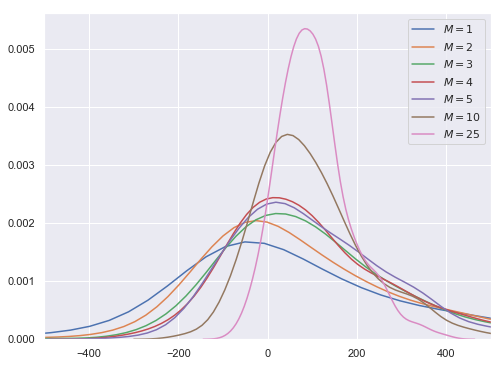

In [4]:
# To check the variation / "unreliability" of the gradient estimate we repeat 
# several times for the same lambda value and notice difference

# Location to check -- close to the data mean (at +10). 
# The prior will move the variational optimium **slightly** away from the data mean, 
# but due to the large prior variance of mu this should be a very limited effect.
# We should therefore expect a positive derivative (since we want to move 
# q_mu_lambda towards the data mean, that is, **increase** it)
q_mu_lambda = 9

plt.figure(figsize=(8,6))
sns.set()
# Do with different sample sizes
for sample_count in [1, 2, 3, 4, 5, 10, 25]:

    #loop
    q_grad = []
    for t in range(500):
        q_grad.append(grad_estimate(q_mu_lambda, samples=sample_count))
    
    sns.distplot(q_grad, hist=False, label="$M = {:d}$".format(sample_count))
    
    # Report back
    print("M = {:2d} sample(s) in BBVI -- Mean of gradient: {:7.3f}; Std.dev. of gradient: {:7.3f}".format(
        sample_count, np.mean(q_grad), np.std(q_grad)))

plt.xlim([-500, 500])
plt.show()      
